In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator, MultipleLocator
import numpy as np

from astropy import constants as c

Grav = c.G.si.value
M_sun = c.M_sun.si.value

import diskwarp
from diskwarp import helper

#%matplotlib widget
#%config InlineBackend.figure_format = 'retina'

# Local plotting scripts
import plots as pl

# Add local eddy version to path
import sys

path = '/home/moon/azuleta/gitcommon/eddy/'
sys.path.append(path)
from eddy import rotationmap

## Set the system geometrical properties

In [82]:
d = 140. # pc

PA = 0.
inc = 30.

tilt  = 0.
twist = 0.
w_r0  = 0.3#0.4 # 0.4 # 
w_dr  = 0.1#0.2 # being r0/4 doesnt affect


## Make the eddy velocity map

Create a cube object

In [83]:
path = './disk_incl10.0phi0.0_inc30.0PA45.0_r040dr10_M1.fits'
uncertainty = './disk_incl10.0phi0.0_inc30.0PA45.0_r040dr10_dM1.fits'

cube = rotationmap(path=path,
                   uncertainty=uncertainty)#, FOV=1.0)
# Not important
#cube.plot_data()

In [84]:
# Dictionary to contain the disk parameters.
params = {}

# Start with the free variables in p0.
params['x0'] = 0.0
params['y0'] = 0.0
params['vlsr'] = 0.
params['dist'] = d # parsec
params['PA'] = PA + 90
params['inc'] = inc
params['mstar'] = 2.4

# Warp parameters
params['w_i'] = 0#20.
params['w_t'] = 1#35.
params['w_r0'] = 2#0.242
params['w_dr'] = 3#0.18

p0 = [30., 45., 0.20, 0.20]

# Surface parameters
params['z0'] = 0.0#.1

In [85]:
x0   = 0.0
y0   = 0.0
w_i = tilt
w_t = twist
w_r0 = w_r0 # 0.4 # 
w_dr = w_dr # being r0/4 doesnt affect

23071.47191716337
(200, 200)


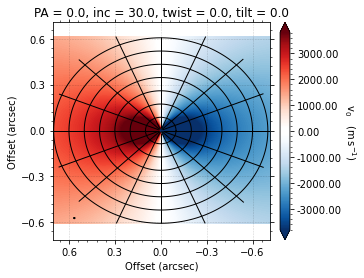

In [86]:
samples = np.array([[w_i, w_t, w_r0, w_dr]])

model = cube.evaluate_models(samples=samples, params=params)

# Get vmin vmax for Til's method
vmin, vmax = np.nanpercentile(model, [2, 98])
# Get the surface
fig_model = cube.plot_model_surface(samples,
                                    params,
                                    return_fig=True)
ax_model = fig_model.get_axes()[0]

# Overplot the surface

cube.plot_model(model=model, ax=ax_model, return_fig=False)


ax_model.set_title(f'PA = {PA}, inc = {inc}, twist = {twist}, tilt = {tilt}')

xlim = ax_model.get_xlim()
ylim = ax_model.get_ylim()
print(np.nanmax(model))
#fig_model.savefig(f'eddy_PA{PA}inc{inc}T{twist}t{tilt}.pdf', dpi=500, bbox_inches='tight')

print(model.shape)

## Make the velocity map with Til's method

In [87]:
### General definitions of disk parameters

In [88]:
n_phi = 256
r_i = np.linspace(0.0, 100, 201)
r_c = 0.5 * (r_i[1:] + r_i[:-1])

surf     = helper.get_surface(r_i=r_i, nphi=n_phi)
p0_i     = surf['points_i']
p0_c     = surf['points_c']
ri       = surf['ri']
rc       = surf['rc']
phic     = surf['phic']
phii     = surf['phii']
nr, nphi = p0_c.shape[:-1]

In [89]:
r0 = (206265*d)*np.tan(w_r0/206265)*np.cos(np.deg2rad(w_i/2))
dr = (206265*d)*np.tan(w_dr/206265)*np.cos(np.deg2rad(w_i/2))

print(r0, dr)
tilt = tilt
twist = twist

warp_c = helper.warp(r_c, i_in=tilt, r0=r0, dr=dr)# + np.deg2rad(inc)
warp_i = helper.warp(r_i, i_in=tilt, r0=r0, dr=dr)# + np.deg2rad(inc)

twist_i = helper.twist(r_i, phi=twist, r0=r0, dr=dr)#  + np.deg2rad(PA)
twist_c = helper.twist(r_c, phi=twist, r0=r0, dr=dr)#  + np.deg2rad(PA)

42.000000000029615 14.0000000000011


Calculate the velocities of all centers and edges

In [90]:
M_star = 2.4 * M_sun

v0_c = (p0_c[:, :, 0]**2 + p0_c[:, :, 1]**2)**-0.25
v0_c = v0_c * np.sqrt(Grav * M_star/ c.au.cgs.to('m').value) # AU TO CGS
v0_c = v0_c[None, :, :] * np.array([-np.sin(phic), np.cos(phic), np.zeros_like(phic)])
v0_c = np.moveaxis(v0_c, 0, 2)

v0_i = (p0_i[:, :, 0]**2 + p0_i[:, :, 1]**2)**-0.25
v0_i = v0_i * np.sqrt(Grav * M_star/ c.au.cgs.to('m').value)
v0_i = v0_i[None, :, :] * np.array([-np.sin(phii), np.cos(phii), np.zeros_like(phii)])
v0_i = np.moveaxis(v0_i, 0, 2)

Define the inclination of the observer

In [91]:
inc_obs = np.deg2rad(inc)
PA_obs  = np.deg2rad(PA)
azi     = np.deg2rad(0)

## Apply the warp/twist

In [92]:
p1_i = diskwarp.fmodule.apply_matrix2d_r(p0_i, warp_i, twist_i, inc_obs, PA_obs, azi)
v1_i = diskwarp.fmodule.apply_matrix2d_r(v0_i, warp_i, twist_i, inc_obs, PA_obs, azi)
#p1_i = diskwarp.fmodule.apply_matrix2d(p0_i, warp_i, twist_i, inc_obs, PA_obs, azi)
#v1_i = diskwarp.fmodule.apply_matrix2d(v0_i, warp_i, twist_i, inc_obs, PA_obs, azi)

## Interpolate on sky plane

In [108]:
_gx = np.linspace(-r_i[-1], r_i[-1], 200 + 1)
_gy = np.linspace(-r_i[-1], r_i[-1], 200 + 1)
img_xi, img_yi = np.meshgrid(_gx, _gy, indexing='ij')
img_xc = 0.5 * (img_xi[1:, 1:] + img_xi[:-1, 1:])
img_yc = 0.5 * (img_yi[1:, 1:] + img_yi[1:, :-1])

In [94]:
X, Y, Z = p1_i.T
vxi, vyi, vzi = v1_i.T

img_z, img_v = diskwarp.fmodule.interpolate_grid(X, Y, Z, vzi, img_xc, img_yc)
_,     img_r = diskwarp.fmodule.interpolate_grid(X, Y, Z, ri.T, img_xc, img_yc)

In [95]:

img_v[img_v==img_v[0,0]] = np.nan
img_r[img_r==img_r[0,0]] = np.nan

print(img_v.shape)

(200, 200)


Make the axes entent match with eddy

In [96]:
RRR = 100 # AU

# Get the arcsec extention

p = RRR/d # arcsec
pp = p #* np.cos(inc_obs)

__gx = np.linspace(-pp, pp, img_xi.shape[0]-1)
__gy = np.linspace(-p, p, img_xi.shape[1]-1)

img_xi_, img_yi_ = np.meshgrid(__gx, __gy, indexing='ij')


tvals = np.arctan2(img_yi_, img_xi_)

18091.474020320788


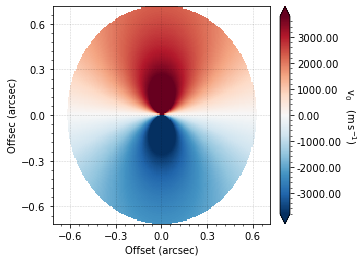

In [97]:
figV, axV = plt.subplots()

vmin, vmax = np.nanpercentile(model, [2, 98])
kwargsV = {'vmin':vmin, 'vmax':vmax}
#surf = axV.pcolormesh(img_xi_, img_yi_, img_v, cmap='RdBu_r', vmin=vmin, vmax=vmax)
surf = pl.plot_vel(img_xi_, img_yi_, img_v, ax=axV, **kwargsV)
cb = figV.colorbar(surf, ax=axV, extend='both', pad=0.03, format='%.2f', fraction=0.046)
cb.set_label(label=r'${\rm v_{0} \quad (m\,s^{-1})}$', rotation=270, labelpad=15)
cb.minorticks_on()

print(np.nanmax(img_v))
# Plot the contour

#axV.contour(img_xi_, img_yi_, img_r, 10, colors='k', linewidths=0.5)
#axV.contour(img_xi_, img_yi_, img_v, np.arange(-6000, 6000, 800), colors='b', linewidths=1.0)

#axV.set_title(f'PA = {PA}, inc = {inc}, twist = {twist}, tilt = {tilt}')

#axV.set_xlim(xlim)
#axV.set_ylim(ylim)

#figV.savefig(f'til_PA{PA}inc{inc}T{twist}t{tilt}.pdf', dpi=500, bbox_inches='tight')

# Residual

In [98]:
# TO DO.
# PLOT 3 AXES AT THE SAME TIME TO COMPARE THE SHAPESSSSSS

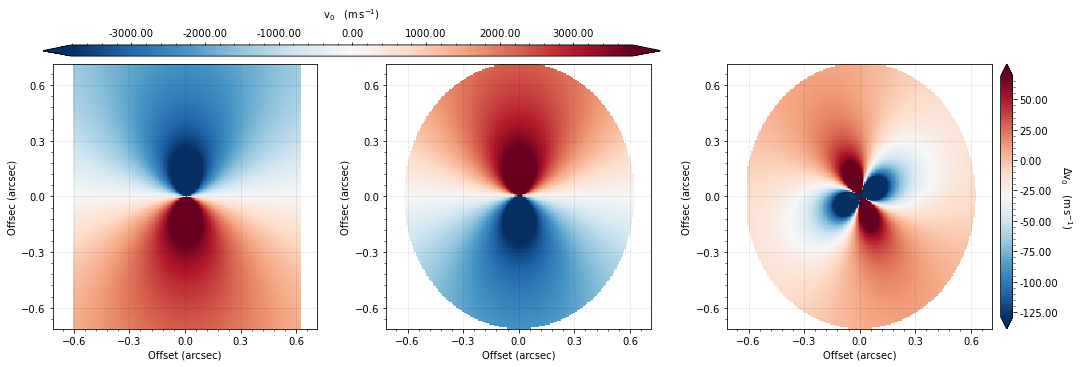

In [106]:
residual = (model+img_v)
vminr, vmaxr = np.nanpercentile(residual, [2, 98])

kwargs1 = {'vmin':vmin, 'vmax':vmax}
kwargs2 = {'vmin':vmin, 'vmax':vmax}
kwargs3 = {'vmin':vminr, 'vmax':vmaxr}

figR, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

im1 = pl.plot_vel(img_xi_, img_yi_, model, ax=ax1, contours=False, **kwargs1)

im2 = pl.plot_vel(img_xi_, img_yi_, img_v, ax=ax2, contours=False, **kwargs2)

im3 = pl.plot_vel(img_xi_, img_yi_, residual, ax=ax3, contours=False, **kwargs3)
#ax3.contour(img_xi_, img_yi_, img_r, 15, colors='k', linewidths=0.5)


#
#print(ax1.get_position().x0)
cb1 = figR.colorbar(im1, ax=(ax1, ax2), extend='both', pad=0.03, format='%.2f', fraction=0.046, location='top', aspect=50)
cb1.set_label(label=r'${\rm v_{0} \quad (m\,s^{-1})}$', rotation=0, labelpad=10)
cb1.minorticks_on()
#
cb2 = figR.colorbar(im3, ax=ax3, extend='both', pad=0.03, format='%.2f', fraction=0.046)
cb2.set_label(label=r'${\rm \Delta v_{0} \quad (m\,s^{-1})}$', rotation=270, labelpad=15)
cb2.minorticks_on()

#figR.savefig(f'residual_PA{PA}inc{inc}T{twist}t{tilt}.pdf', dpi=500, bbox_inches='tight')